# El impacto de TikTok en las tendencias musicales: Un análisis comparativo con Spotify

## Grupo: “Si hay que ser minero”

## Integrantes:
##### - Gabriel Arias
##### - Gabriela González
##### - Benjamín Ramírez

## TEL356    Mauricio Araya

El proyecto parte de la hipótesis de que existe una correlación positiva entre la popularidad de canciones en Spotify y en TikTok. Para ello, primero necesitamos un dataset. Al no haber opciones disponibles, nos propusimos hacerlo nosotros mismos.

Para recabar la información necesaria para el proyecto se requieren tres tipos de datos: canciones populares en Spotify por día, TikToks en tendencia por día y una forma de obtener el sonido real que se reproduce en TikTok (ya que la mayoría están mal catalogados como “original sound”). Para esto se utilizará Shazam y su API.

Comenzamos creando un servicio automatizado en GitHub que recaba el top 50 de canciones en Spotify (Spotify no permite ver visualizaciones de canción y solo tenemos acceso al top 50 de canciones más escuchadas) y usamos una API de TikTok para obtener información de los videos en tendencia por día.

Con esta información se pueden generar dataframes CSV de la información recopilada diariamente gracias a la automatización de GitHub Actions.

La incorporación de Shazam al proyecto se debió a la pobre información de TikTok respecto a sus canciones, por lo que tuvimos que intentar identificar los audios con Shazam. Utilizando la API de Shazam, intentamos reconocer la música de todos los TikToks disponibles en el archivo CSV generado.

El proceso detallado de la creación de estos datasets se puede ver en la siguiente figura.

![Diagrama sin título.drawio(1).png](https://raw.githubusercontent.com/gabrielariasv/Mineriadedatosdataframegenerator/main/images/Diagrama_sin_ttulo.drawio(1).png)

## Herramientas utilizadas;

### Spotify API: [https://developer.spotify.com/](https://developer.spotify.com/)

API oficial de Spotify la cual con una cuenta y un request puedes obtener información acerca de una determinada canción o playlist, en este caso nos enfocamos en la función playlist para obtener la playlist de top50 canciones diariamente

### TikTok API: https://github.com/davidteather/TikTok-Api

API no oficial de TikTok en forma de web wrapper, solo con el requerimiento de una id de cookies ya se puede obtener información de videos, música, usuarios, etc. para el caso del proyecto se utiliza la función de trending, la cual otorga videos populares en dicho día.

### Shazam API (Shazamio): [https://pypi.org/project/shazamio/](https://pypi.org/project/shazamio/)

API no oficial de Shazam, permite realizar peticiones y reconocer tracks de audio enviándolas como peticiones a la API, en el caso del proyecto muy útil para designar las canciones reales de los videos

### yt-dlp: [https://pypi.org/project/yt-dlp/](https://pypi.org/project/yt-dlp/)

Aplicación de descarga de video en múltiples formatos para múltiples páginas, en este caso fue muy útil para descargar los TikToks para realizar peticiones a Shazam.

## Observaciones a tomar en cuenta:

Cabe destacar que al recopilar información se notó lo siguiente

- No todos los TikToks tienen canciones, por lo tanto para el proyecto se utilizaran solo los que contienen canciones
- Hubo un día en que la aplicación falló, ese día no se considerará para el análisis
- Los dataset en bruto pueden tener información repetida, por lo que requieren de un filtro posterior
- Los datos son válidos para los servidores de GitHub (EEUU)

# Trabajo con los Dataset

- Importar datasets como dataframes de pandas
- Graficar dataset de Spotify con el top 50 de cada día
- Arreglar dataframe de Shazam y TikTok, eliminando filas duplicadas
- Combinar ambos dataframes según el id de música en un nuevo dataframe
- Graficar visualizaciones por día por canción de Shazam
- Tomar las canciones en común de ambas plataformas mediante el título
- Graficar las visualizaciones totales de dichas canciones por día comparándolas con su posición en la lista de Spotify

notas: los archivos de dataset tienen nombre `ShazamData.csv` , `SpotifyData.csv`  y `TiktokData.csv`

cada uno tiene los siguientes parámetros:

### ShazamData:

- **musicId**: id de música en TikTok
- **trackName**: Nombre de la canción
- **artists**: Artistas de la canción

### SpotifyData:

- **position**: Posición en el TOP50 de Spotify
- **trackName**: Nombre de la canción
- **trackId**: Id de canción en Spotify (Sin usar)
- **artists**: Artistas de la canción
- **date**: Fecha de los datos

### TikTokData:

- **position**: Posición en las peticiones de la API de Tiktok (Sin usar no representativo de posicionamiento)
- **title**: Título de tiktok (Si tiene)
- **user**: Usuario que realiza el video
- **views**: Numero de visitas
- **likes**: Número de me gustas
- **comments**: Número de comentarios
- **original_music**: Música original registrada por tiktok, generalmente mal clasificada (sin usar)
- **musicTitle**: Nombre de la canción registrada por TikTok
- **musicId**: Id de canción en Tiktok
- **date**: Fecha de los datos

El código realizado a los datasets con sus resultados son los siguientes


In [41]:
import pandas as pd
import matplotlib.pyplot as plt


In [42]:
shazam_df = pd.read_csv("data/ShazamData.csv", encoding = "ISO-8859-1")
spotify_df = pd.read_csv("data/spotifyData.csv", encoding = "ISO-8859-1")
tiktok_df = pd.read_csv("data/tiktokData.csv", encoding = "ISO-8859-1")


In [43]:
pattern = r'\s*(\(|\[).*?(Slowed|Reverb|sped up|Speed|Radio Edit|remix|Lofi|Remix|Mix|VHS|remastered|SLOWED|SUPER SLOWED|Sped Up|slowed|reverb).*?(\)|\])\s*'
shazam_df['trackName'] = shazam_df['trackName'].str.replace(pattern, '', regex=True)
shazam_df
print(shazam_df.iloc[424])

musicId      7323282980226140960
trackName                 EEYUH!
artists             H.R. & Irokz
Name: 424, dtype: object


### Agrupar canciones por día en spotifyData.csv

In [44]:
spotify_df["date"] = spotify_df["date"].str[:10]
grouped_by_day = spotify_df.groupby("date")
daily_data_df = pd.DataFrame()

In [45]:
import plotly.express as px

# Ordena el dataframe por 'date' y 'position'
spotify_df.sort_values(['date', 'position'], inplace=True)

# Selecciona los 5 tracks más populares de cada día
df_populares = spotify_df.groupby('date').head(5)

# Obtiene los nombres de los tracks más populares
tracks_populares = df_populares['trackName'].unique()

# Filtra el dataframe original para incluir solo los tracks más populares
df_filtrado = spotify_df[spotify_df['trackName'].isin(tracks_populares)]

# Crea el gráfico de líneas
fig = px.line(df_filtrado, x='date', y='position', color='trackName', title='Evolución temporal de la posición en la lista')

# Invierte el eje y para que la posición 1 aparezca en la parte superior
fig.update_yaxes(autorange="reversed")

fig.show()

fig = px.line(spotify_df, x='date', y='position', color='trackName', title='Evolución temporal de la posición en la lista')

fig.update_yaxes(autorange="reversed")

fig.update_layout(height=800)

fig.show()

In [62]:
shazam_df_fixed = shazam_df.drop_duplicates()
tiktok_df_fixed = tiktok_df.drop_duplicates()

tiktokshazam_df = pd.merge(tiktok_df_fixed, shazam_df_fixed, on='musicId', how='inner')

In [47]:
grouped_by_date_song = tiktokshazam_df.groupby(['date', 'trackName']).agg({'views': 'sum'})
grouped_by_date_song.reset_index(inplace=True)

fig = px.line(grouped_by_date_song, x='date', y='views', color='trackName', markers=True, title='Suma de views por canción en TikTok')

fig.update_layout(height=800)

fig.show()

In [48]:
spotifytiktok_df = pd.merge(tiktokshazam_df, spotify_df, on=['trackName','date'], how='inner')
spotifytiktok_df.head(10)

grouped_by_date_song = spotifytiktok_df.groupby(['date', 'trackName']).agg({'views': 'sum'})
grouped_by_date_song.reset_index(inplace=True)

fig = px.line(grouped_by_date_song, x='date', y='views', color='trackName', markers=True, title='Suma de views por canción en TikTok')

fig.update_layout(height=800)

fig.show()

### Gráfico de dispersión para visualizar la relación entre las vistas en TikTok y las posiciones en Spotify.

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el gráfico de dispersión
fig = px.scatter(
    spotifytiktok_df,
    x='views',
    y='position_y',
    color='trackName',
    symbol='trackName',
    title='Relación entre Vistas en TikTok y Posición en Spotify',
    labels={
        'views': 'Vistas en TikTok',
        'position_y': 'Posición en Spotify'
    },
    template='plotly_white'
)

# Ajustar la leyenda
fig.update_layout(
    legend_title_text='Canción',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.05,
        title_font=dict(size=10),
        font=dict(size=9)
    )
)

# Invertir el eje Y para que la posición 1 esté en la parte superior
fig.update_yaxes(autorange="reversed")
fig.show()

Como se puede visualizar la mayoría de los puntos se encuentran a la izquierda del gráfico, esto es debido a que la mayoría de las canciones se vuelven popular en el momento y después quedan olvidados en el tiempo. Sin embargo, las que se mantienen en el top de Spotify, son las que se vuelven populares en Tiktok. Esto nos da a entender que gracias a las vistas de Tiktok las canciones se mantienen en el Top de Spotify.

### Gráfico de las posiciones en Spotify en los días siguientes. Esto puede ayudar a entender el impacto a largo plazo de TikTok en Spotify.

In [50]:

# Crear el gráfico de líneas para tendencias a largo plazo
fig = px.line(
    spotifytiktok_df,
    x='date',
    y='position_y',
    color='trackName',
    title='Tendencias a Largo Plazo',
    labels={'date': 'Fecha', 'position_y': 'Posición en Spotify'}
)

fig.update_yaxes(autorange="reversed")
fig.show()

Con este gráfico se comprueba lo que se menciona anteriormente, es decir, de que existen canciones que se vuelven populares en Spotify por un periodo muy corto de tiempo y no alcanzan la popularidad en TikTok. 

### Gráfico para identificar los usuarios de TikTok más influyentes y analizar cómo sus videos afectan la popularidad de las canciones en Spotify.

In [61]:
# Agrupar por usuario y calcular la suma de vistas y likes
influencer_impact = tiktok_df.groupby('user').agg({'views': 'sum', 'likes': 'sum'}).reset_index()

# Ordenar por vistas y seleccionar los 20 principales influencers
top_influencers = influencer_impact.sort_values(by='views', ascending=False).head(20)

# Crear el gráfico de barras
fig = px.bar(
    top_influencers,
    x='user',
    y='views',
    color='likes',
    title='Impacto de Influencers',
    text='views', 
    labels={'views': 'Vistas', 'user': 'Usuario', 'likes': 'Me gusta'}
)

# Ajustar la orientación de las etiquetas de los ejes
fig.update_layout(
    xaxis_tickangle=-45,
    height=600,
    width=1000
)
fig.show()

Este gráfico nos ayuda a entender que no solamente las views de un video de TikTok son útiles para realizar un análisis de correlación de la popularidad de una canción en un video de TikTok con su tendencia en Spotify, sino que también lo son los likes. En este gráfico nos da a entender que las view están correlacionadas con los likes, es decir, si un usuario en TikTok tiene mas views en su perfil, a su vez, tiene mas likes.

### Gráfico modificado de dispersión de la relación entre las views de TikTok y la posicion en Spotify. 

In [51]:
spotifytiktok_df['date'] = pd.to_datetime(spotifytiktok_df['date'])
song_impact_tiktok = spotifytiktok_df.groupby('trackName').agg({'views': 'sum', 'likes': 'sum'}).reset_index()
song_impact_tiktok.rename(columns={'trackName': 'Canción', 'views': 'Vistas en TikTok', 'likes': 'Likes en TikTok'}, inplace=True)

# Calcular la posición promedio por canción en Spotify
song_impact_spotify = spotifytiktok_df.groupby('trackName').agg({'position_y': 'mean'}).reset_index()
song_impact_spotify.rename(columns={'trackName': 'Canción', 'position_y': 'Posición Promedio en Spotify'}, inplace=True)

# Fusionar los datasets de impacto en TikTok y posiciones en Spotify
combined_df = pd.merge(song_impact_tiktok, song_impact_spotify, on='Canción')

# Crear el gráfico de dispersión con vistas en el eje X y likes en el tamaño de los puntos
fig = px.scatter(
    combined_df,
    x='Vistas en TikTok',
    y='Posición Promedio en Spotify',
    size='Likes en TikTok',
    color='Canción',
    title='Relación entre Vistas en TikTok y Posición en Spotify',
    labels={'Vistas en TikTok': 'Vistas en TikTok', 'Posición Promedio en Spotify': 'Posición en Spotify'},
    template='plotly_white',
    hover_data={'Likes en TikTok': True}  # Agregar likes en el hover
)

fig.update_yaxes(autorange="reversed")

# Ajustar las etiquetas del eje X a millones
fig.update_xaxes(tickvals=[0, 200_000_000, 400_000_000, 600_000_000, 800_000_000, 1_000_000_000],
                 ticktext=['0M', '200M', '400M', '600M', '800M', '1000M'])
fig.show()

Este gráfico es muy similar al anteriormente visto, referente a la relación entre vistas en TikTok y su posición en Spotify, sin embargo, ahora se considera una variable importante que son los likes, ahora las canciones están agrupadas por su cantidad de likes en TikTok, es decir, mientras más grande el circulo, mas like tiene esa canción. Al analizar este gráfico podemos observar que la canción MILLION DOLLAR BABY, presenta una cantidad de likes y de vistas considerablemente grande y permanece en una posición elevada en el top de Spotify.

### Gráfico de dispersión de la relación de likes vs la  posición en spotify.

In [53]:
spotifytiktok_df['date'] = pd.to_datetime(spotifytiktok_df['date'])
song_impact_tiktok = spotifytiktok_df.groupby('trackName').agg({'views': 'sum', 'likes': 'sum'}).reset_index()
song_impact_tiktok.rename(columns={'trackName': 'Canción', 'views': 'Vistas en TikTok', 'likes': 'Likes en TikTok'}, inplace=True)

# Calcular la posición promedio por canción en Spotify
song_impact_spotify = spotifytiktok_df.groupby('trackName').agg({'position_y': 'mean'}).reset_index()
song_impact_spotify.rename(columns={'trackName': 'Canción', 'position_y': 'Posición Promedio en Spotify'}, inplace=True)

# Fusionar los datasets de impacto en TikTok y posiciones en Spotify
combined_df = pd.merge(song_impact_tiktok, song_impact_spotify, on='Canción')

# Crear el gráfico de dispersión con likes en el eje X y vistas en el tamaño de los puntos
fig = px.scatter(
    combined_df,
    x='Likes en TikTok',
    y='Posición Promedio en Spotify',
    size='Vistas en TikTok',
    color='Canción',
    title='Relación entre Likes en TikTok y Posición en Spotify',
    labels={'Likes en TikTok': 'Likes en TikTok', 'Posición Promedio en Spotify': 'Posición en Spotify'},
    template='plotly_white',
    hover_data={'Vistas en TikTok': True}  # Agregar vistas en el hover
)

fig.update_yaxes(autorange="reversed")
fig.show()

En este gráfico se realiza la relación de likes vs la posición en spotify, donde los círculos más grandes significan que tiene más views. Al analizarlo, nos damos cuenta de que ciertas canciones cumplen que al tener más likes en TikTok, aumenta su posición en Spotify. Lo que se puede afirmar que los likes, al igual que las views, son un factor igual de importantes para la hipótesis planteada en el proyecto.

Los siguientes códigos son con el objetivo de utilizar modelos de aprendizaje automático para predecir las futuras posiciones en Spotify basándose en las métricas de TikTok. Para ello vamos a utilizar distintos modelos (La mayoría vista en clases para realizar esta predicción) estos modelos son Regresion lineal, KNeighbors,DecisionTree y RandomForest

In [54]:
import numpy as np
from sklearn.model_selection import train_test_split

# Seleccionar características y etiquetas
X = spotifytiktok_df[['views', 'likes']]
y = spotifytiktok_df['position_y']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Regresión Lineal

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Entrenar el modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_linear = linear_model.predict(X_test)

# Evaluar el modelo
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error (Linear Regression): {mse_linear}')

Mean Squared Error (Linear Regression): 189.95254333025153


### KNeighbors

In [56]:
from sklearn.neighbors import KNeighborsRegressor

# Entrenar el modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_knn = knn_model.predict(X_test)

# Evaluar el modelo
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f'Mean Squared Error (KNN): {mse_knn}')

Mean Squared Error (KNN): 169.90608695652173


### Decision Tree

In [57]:
from sklearn.tree import DecisionTreeRegressor

# Entrenar el modelo de árbol de decisión
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_tree = tree_model.predict(X_test)

# Evaluar el modelo
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f'Mean Squared Error (Decision Tree): {mse_tree}')

Mean Squared Error (Decision Tree): 186.7826086956522


### RandomForest

In [58]:
from sklearn.ensemble import RandomForestRegressor

# Entrenar el modelo de random forest
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_forest = forest_model.predict(X_test)

# Evaluar el modelo
mse_forest = mean_squared_error(y_test, y_pred_forest)
print(f'Mean Squared Error (Random Forest): {mse_forest}')

Mean Squared Error (Random Forest): 131.5791720108696


### Gráfico de dispersión de predicciones V/S valores reales de posiciones de Spotify

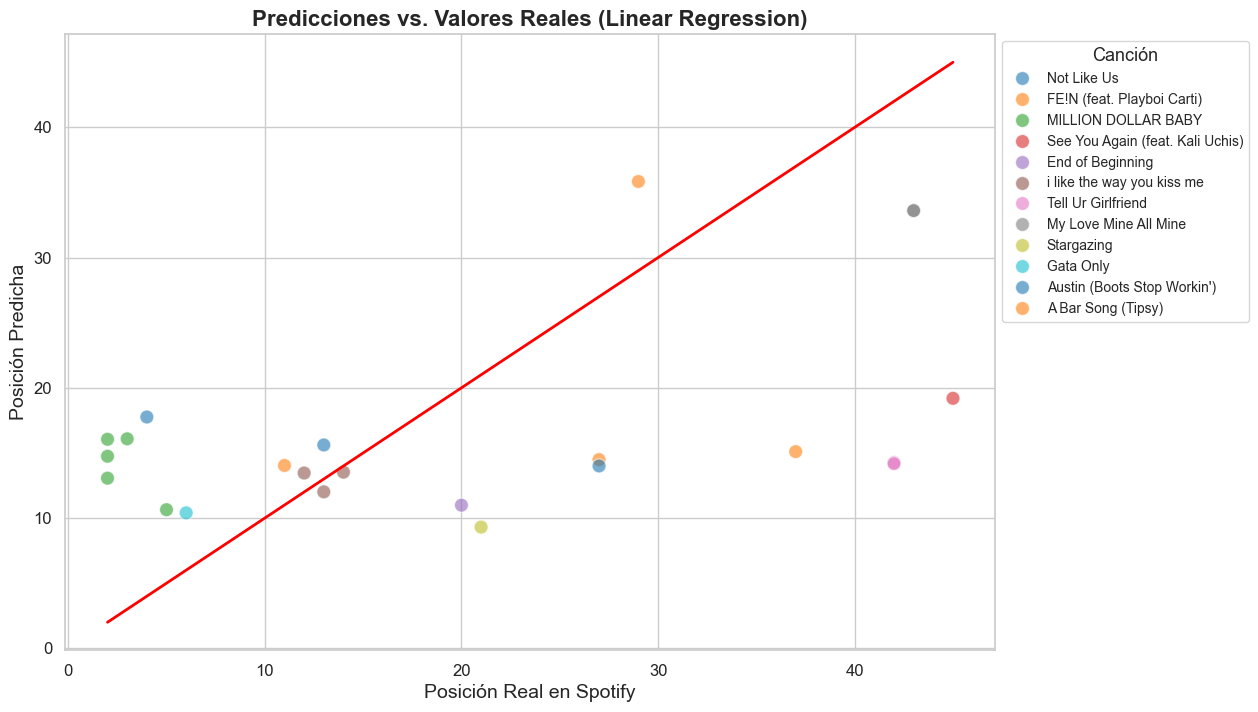

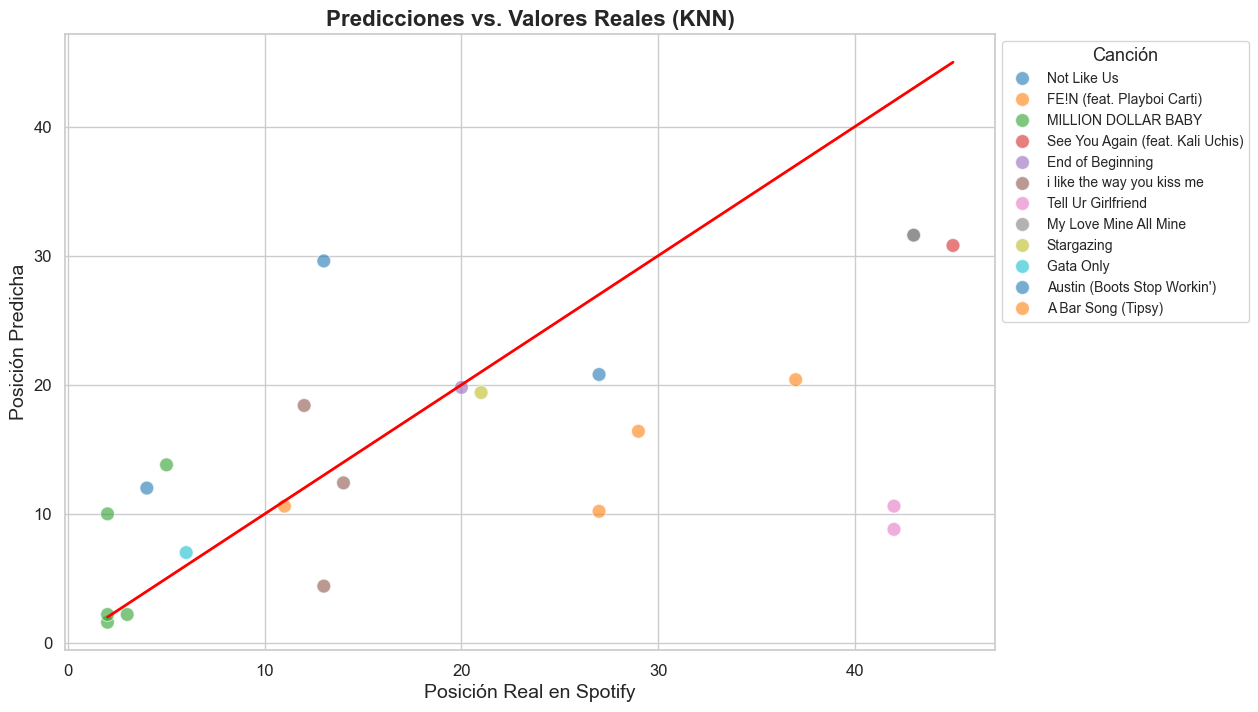

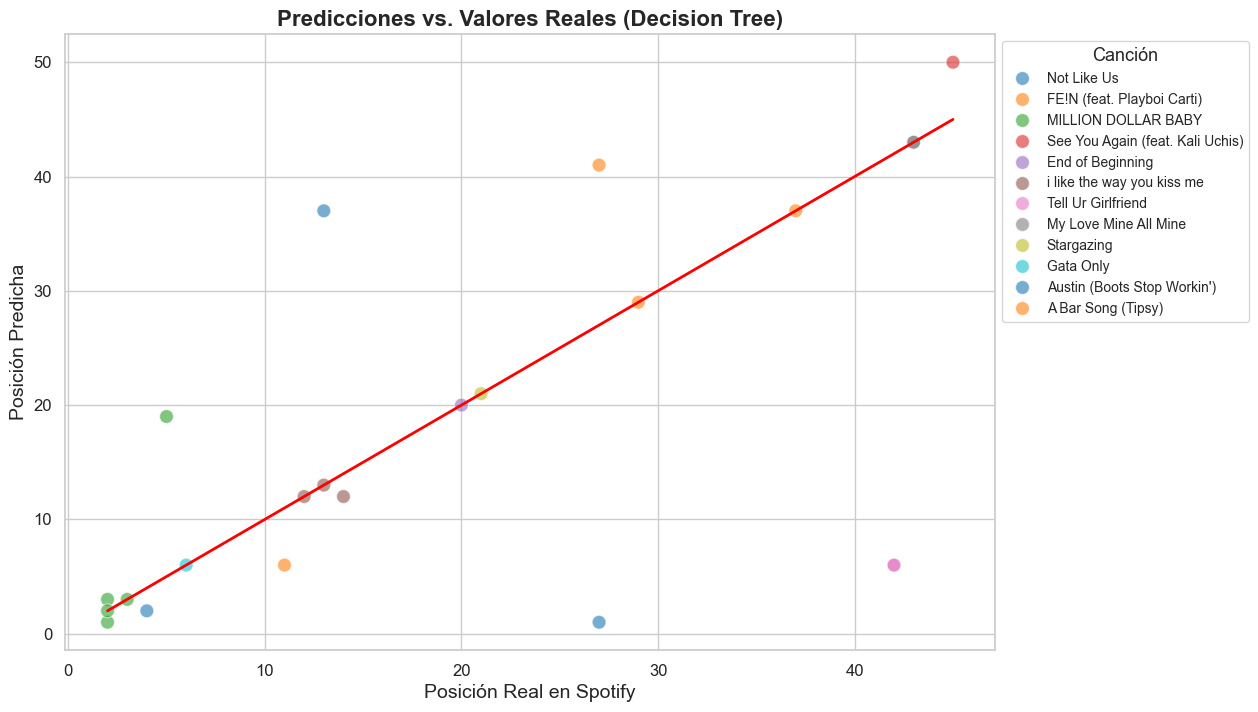

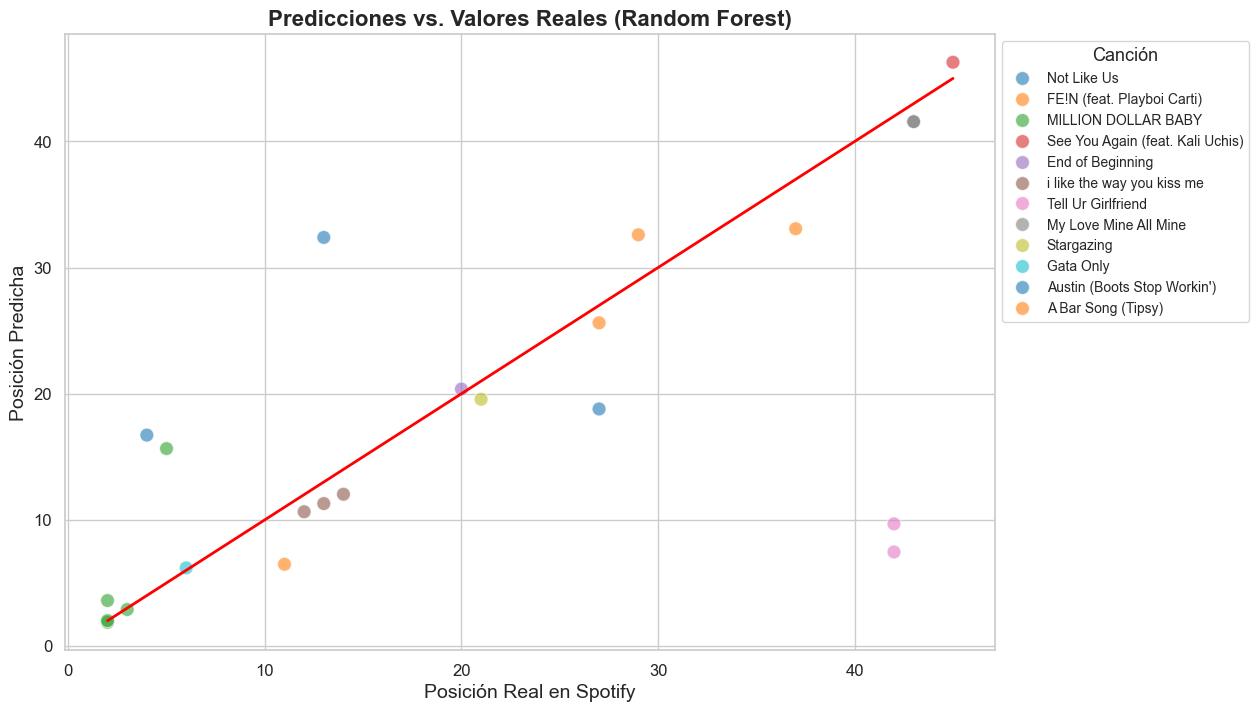

In [59]:
def plot_predictions(y_test, y_pred, title, labels):
    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid")
    ax = sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=100, hue=labels, palette='tab10')
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red', lw=2, ax=ax)
    ax.set_xlabel('Posición Real en Spotify', fontsize=14)
    ax.set_ylabel('Posición Predicha', fontsize=14)
    ax.set_title(title, fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Canción', loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title_fontsize='13')
    plt.show()

# Ejemplo de uso con etiquetas de los datos (suponiendo que labels es una serie con los nombres de las canciones)
labels = spotifytiktok_df.loc[X_test.index, 'trackName']

# Visualizar las predicciones vs. los valores reales sin etiquetas
plot_predictions(y_test, y_pred_linear, 'Predicciones vs. Valores Reales (Linear Regression)', labels)
plot_predictions(y_test, y_pred_knn, 'Predicciones vs. Valores Reales (KNN)', labels)
plot_predictions(y_test, y_pred_tree, 'Predicciones vs. Valores Reales (Decision Tree)', labels)
plot_predictions(y_test, y_pred_forest, 'Predicciones vs. Valores Reales (Random Forest)', labels)



Viendo los gráficos y los Mean Squared Error de cada uno , podemos afirmar que el mejor modelo es RandomForest, sin embargo, al inicio se creía que el mejor sería Regresion Lineal debido a la poca cantidad de datos, pero al analizar los gráficos y los Mean Squared Error de cada uno el mejor modelo es RandomForest, ya que es el mejor que se ve en los gráficos y el mean squared error de esta es el que da más bajo.

### Interpretacion de modelo RandomForest

Mean Squared Error (Random Forest): 131.5791720108696


C:\Users\Benja\AppData\Local\Temp\ipykernel_11304\453734644.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




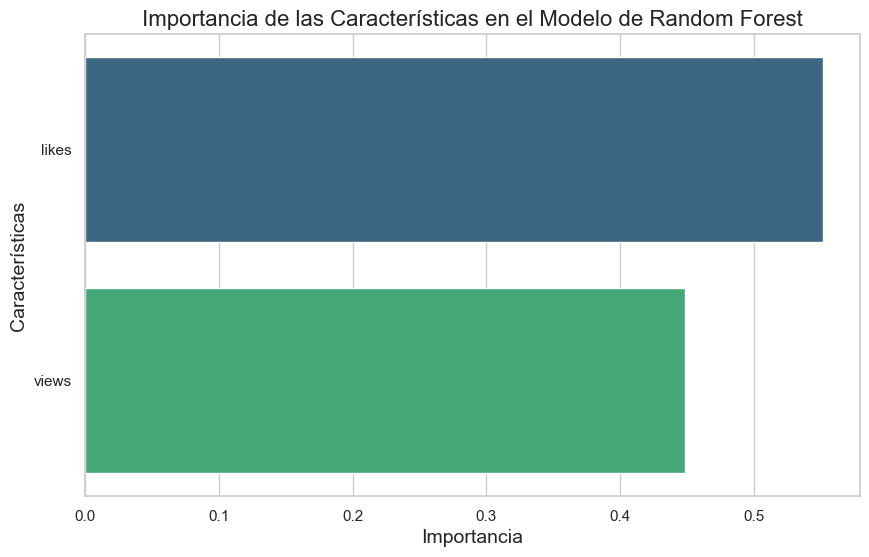

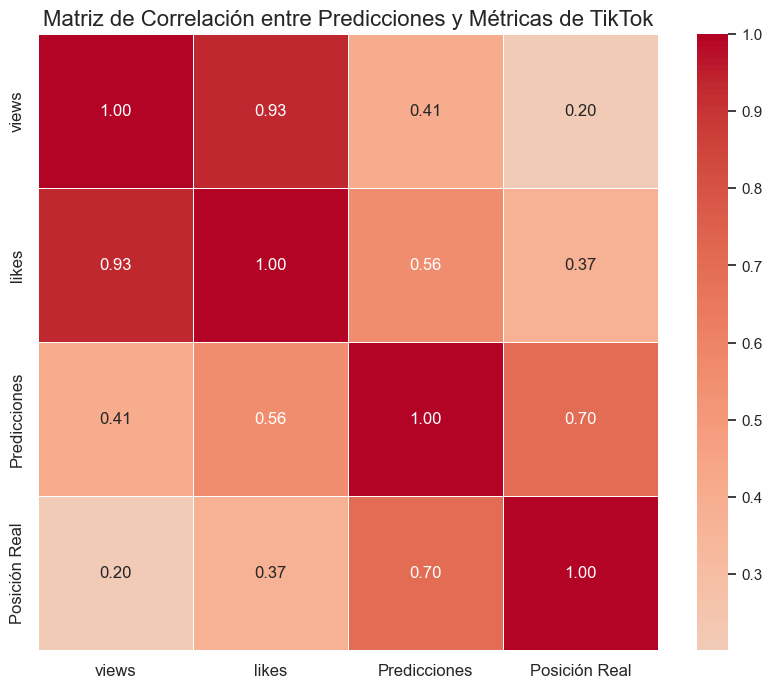

In [60]:
# Entrenar el modelo de random forest
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_forest = forest_model.predict(X_test)

# Evaluar el modelo
mse_forest = mean_squared_error(y_test, y_pred_forest)
print(f'Mean Squared Error (Random Forest): {mse_forest}')

# Interpretar el Modelo
feature_importances = forest_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Importancia de las Características en el Modelo de Random Forest', fontsize=16)
plt.xlabel('Importancia', fontsize=14)
plt.ylabel('Características', fontsize=14)
plt.show()

# Correlación entre Predicciones y Métricas de TikTok
X_test['Predicciones'] = y_pred_forest
X_test['Posición Real'] = y_test

correlation_matrix = X_test.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")
plt.title('Matriz de Correlación entre Predicciones y Métricas de TikTok', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Al interpretar este modelo, nos damos cuenta de que el factor o característica más importante para realizar las predicciones de futuras posiciones en el top de Spotify, fueron los likes.

### Conclusión

Como conclusión de proyecto , para verificar si existe una correlación positiva entre la popularidad de canciones en Spotify y TikTok, podemos afirmar que tanto para las views como los likes sirven para realizar un análisis profundo de la relación con las canciones top en Spotify. 

A su vez , para verificar que métrica es mejor a utilizar, se analizó modelos de aprendizaje automático para predecir las futuras posiciones en Spotify, donde el mejor modelo resultante fue RandomForest, al interpretar el modelo, se logra visualizar que para realizar una predicción de canciones que pueden estar en el top de Spotify , nos da como resultado que la métrica más importante son los likes.